In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt

from partial_trace import *

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2


In [2]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

We will consider a matrix
$$
\vec{H} := \sum_{i,j=1}^{N} \left[  J^{\text{x}}_{i,j} \vec{\sigma}^{\text{x}}_i \vec{\sigma}^{\text{x}}_j 
    +J^{\text{y}}_{i,j} \vec{\sigma}^{\text{y}}_i \vec{\sigma}^{\text{y}}_j
    +J^{\text{z}}_{i,j} \vec{\sigma}^{\text{z}}_i \vec{\sigma}^{\text{z}}_j \right] 
    + \frac{h}{2} \sum_{i=1}^{N} \sigma_i^{\text{z}}
$$
in the case $\vec{J}^{\text{z}}_{i,j} = 0$ and 
$$
\vec{J}^{\text{x/y}}_{i,j} = \begin{cases} 1 & |i-j| = 1 \\ 0 & \text{otherwise} \end{cases}.
$$


In [3]:
s = 1/2
M = int(2*s+1)

N = 12
n = M**N

N_s = 2
N_b = N-N_s
d_a = M**N_s
d_b = M**N_b

In [4]:
J_t = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if np.abs(i-j)==1:
            J_t[i,j] = 1

In [5]:
%%time
J = 1
h = .3*J

H = get_hamiltonian((J/2)*J_t,(J/2)*J_t,0*J_t,h,s)

CPU times: user 53.8 ms, sys: 271 µs, total: 54.1 ms
Wall time: 54.2 ms


We want to compute
$$
\rho^*(\beta):=
\frac{\operatorname{tr}_{\text{b}}( \exp(-\beta \vec{H}) )}{\operatorname{tr}(\operatorname{tr}_{\text{b}}( \exp(-\beta \vec{H}) ))}.
$$

In [6]:
%%time
# generate list of temperatures to evaluate at
n_βs = 100
βs = 1/np.logspace(-3,3,n_βs)

# sketching
ks = [0,10,30]

# number of random samples
m = 10

CPU times: user 104 µs, sys: 12 µs, total: 116 µs
Wall time: 107 µs


In [7]:
%%time
n_evecs = [0,1,2]

Λk,Qk = sp.sparse.linalg.eigsh(H,k=max(1,max(n_evecs)),which='SA')
E0 = Λk[0]

En,_ = sp.sparse.linalg.eigsh(H,k=1,which='LA')

CPU times: user 112 ms, sys: 3.5 ms, total: 115 ms
Wall time: 29.5 ms


In [8]:
# number of times to independently run the algorithm
n_trials = 10

In [11]:
%%time
np.random.seed(0)
out_all = []
for i in range(n_trials):
    
    out = {}
    for ki,k in enumerate(ks):
        for n_eveci,n_evec in enumerate(n_evecs):
            print(f'trial:{i+1}/{n_trials}, k:{ki+1}/{len(ks)}, nevec:{n_eveci+1}/{len(n_evecs)}')
            clear_output(wait=True)
            
            # setup low-rank matrix and eigenvectors as bottom k
            if k==0:
                Qkk = Qk[:,:n_evec]
            else:
                Z = np.hstack([Qk[:,:n_evec],np.random.randn(n,k-n_evec)])
                q = 20
                for _ in range(q):
                    Z = En * Z - H@Z  # sketch (En I - H) which is PSD
                    Z,_ = np.linalg.qr(Z)    
                Qkk = Z
                
            # use guess of the slowest function to converge and build termination condition
            f_hard = lambda x: np.exp(-np.max(βs)*(x-E0))
            termination_cond = get_termination_cond(f_hard,1e-10,5,verbose=1)
    
            # hard maximum iterations if no convergence
            max_iter = 10
            
            # get quadrature nodes/weights
            out[k,n_evec] = fast_partial_trace_quadrature(H,Qkk,m,d_a,d_b,\
                                                     n_evec=n_evec,\
                                                     reorth=False,
                                                     termination_cond=termination_cond,\
                                                     max_iter=max_iter\
                                                    )
        
    out_all.append(out)

CPU times: user 28.2 s, sys: 284 ms, total: 28.5 s
Wall time: 7.12 s


In [12]:
np.save('data/variance_tests_sketch/variance.npy',out_all,allow_pickle=True)
out_all = np.load('data/variance_tests_sketch/variance.npy',allow_pickle=True)

# Eigenvalues

Now we will compute the eigenvalues of $\rho^*(\beta)$ for all $\beta$

In [14]:
ρ_EVs_all = []
for i in range(n_trials):
    out = out_all[i]
    
    ρ_EVs = {}
    for ki,k in enumerate(ks):
        for n_eveci,n_evec in enumerate(n_evecs):

            if k==0 and m==0:
                continue
                
            ρ_EVs[k,n_evec] = get_ρ_EVs_all(*out[k,n_evec],E0,βs)

    ρ_EVs_all.append(ρ_EVs)


ρ_EVs_true = np.zeros((n_βs,d_a))      
for l,β in enumerate(βs):

    f = lambda x: np.exp(-β*(x-E0))
    ρ_EVs_true[l] = get_solvable_density_EVs(2*h,2*J,β,N)

/home/tyler/Documents/Research Code/faster_partial_trace/partial_trace/solvable_chain.py:15: RuntimeWarning: overflow encountered in exp
  Nk = 1/(1+np.exp(β*λk))


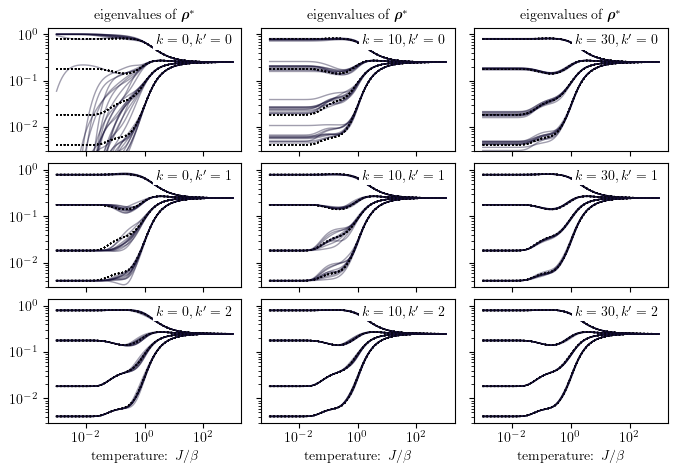

In [15]:
fig,axs = plt.subplots(len(n_evecs),len(ks),figsize=(8,5),sharex=True,sharey=True)
plt.subplots_adjust(bottom=.09,wspace=.1,hspace=.1)


for ki,k in enumerate(ks):
    for n_eveci,n_evec in enumerate(n_evecs):

        axs[n_eveci,ki].text(.95,.95,rf"$k={k}, k'={n_evec}$",ha='right', va='top', transform=axs[n_eveci,ki].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

        for i in range(n_trials):
            ρ_EVs = ρ_EVs_all[i]
        
            c = plt.cm.magma(.1)
            axs[n_eveci,ki].plot(1/βs,ρ_EVs_true,color='k',ls=':',lw=1)

            axs[n_eveci,ki].plot(1/βs,ρ_EVs[k,n_evec],color=c,alpha=.4,lw=1)
    
    
    axs[-1,ki].set_xlabel(rf'temperature: $J/\beta$')
        
    axs[0,ki].set_title(rf'eigenvalues of $\bm\rho^*$',fontsize=10)

plt.yscale('log')
plt.ylim(3e-3,1.4)
plt.xscale('log')

plt.savefig('imgs/solvable_comparison_sketch.pdf')